In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('./titanic/train.csv')
df_test = pd.read_csv('./titanic/test.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
y_train = df.Survived.values.reshape(-1,1)

df.Sex = df.Sex.map({'male':0,'female':1})
df_test.Sex = df_test.Sex.map({'male':0,'female':1})

In [6]:
df.Age.fillna(df.Age.mean(),inplace=True)
df_test.Age.fillna(df_test.Age.mean(),inplace=True)
df_test.Fare.fillna(df_test.Fare.mean(),inplace=True)
df.Embarked.dropna(axis=0,inplace=True)

In [7]:
df.drop(['Ticket','Name','Cabin'],axis=1,inplace=True)
df_test.drop(['Ticket','Name','Cabin'],axis=1,inplace=True)

In [8]:
def Add_One_Hot(data,column,Trunc_colname=False):
    if column not in data.columns: 
        print('Please check column name');
        return data
    one_hot_df = pd.get_dummies(data[column],prefix=column,drop_first=True)
    
    if(Trunc_colname==True):
        one_hot_df.columns = [elem.rstrip().split(' ')[0] for elem in one_hot_df.columns]
        
    data = pd.concat([data.drop(column, axis=1),one_hot_df],axis=1)
    return data

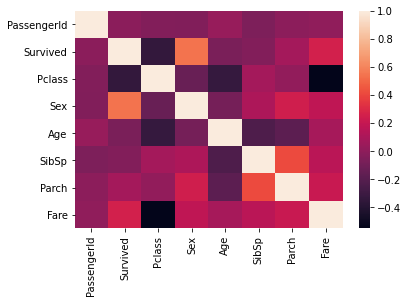

In [9]:
sns.heatmap(df.corr())

In [10]:
df = Add_One_Hot(df,'Pclass')
df_test = Add_One_Hot(df_test,'Pclass')
df = Add_One_Hot(df,'Embarked')
df_test = Add_One_Hot(df_test,'Embarked')

In [11]:
df.drop('Survived',axis=1,inplace=True)
X_train = df.iloc[:,1:].values
X_test = df_test.iloc[:,1:].values

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# from sklearn.ensemble import RandomForestClassifier

# classifier = RandomForestClassifier().fit(X_train,y_train.ravel())
# y_pred = classifier.predict(X_test)

In [21]:
from sklearn.preprocessing import OneHotEncoder

Encoder = OneHotEncoder().fit(y_train)
y_train = Encoder.transform(y_train).toarray()

In [23]:
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model

I = Input(shape=(9))
X = Dense(units=9,activation='relu')(I)
X = Dense(units=18,activation='relu')(X)
X = Dense(units=2,activation='sigmoid')(X)

model = Model(inputs=I,outputs=X)
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [26]:
model.fit(X_train,y_train,epochs=30)

Train on 891 samples
Epoch 1/30
891/891 [==============================] - 0s 62us/sample - loss: 0.4542 - accuracy: 0.7957
Epoch 2/30
891/891 [==============================] - 0s 56us/sample - loss: 0.4507 - accuracy: 0.7957
Epoch 3/30
891/891 [==============================] - 0s 55us/sample - loss: 0.4483 - accuracy: 0.8002
Epoch 4/30
891/891 [==============================] - 0s 49us/sample - loss: 0.4461 - accuracy: 0.7980
Epoch 5/30
891/891 [==============================] - 0s 58us/sample - loss: 0.4451 - accuracy: 0.8070
Epoch 6/30
891/891 [==============================] - 0s 49us/sample - loss: 0.4433 - accuracy: 0.8070
Epoch 7/30
891/891 [==============================] - 0s 65us/sample - loss: 0.4412 - accuracy: 0.8081
Epoch 8/30
891/891 [==============================] - 0s 54us/sample - loss: 0.4400 - accuracy: 0.8109
Epoch 9/30
891/891 [==============================] - 0s 51us/sample - loss: 0.4391 - accuracy: 0.8120
Epoch 10/30
891/891 [==============================]

In [44]:
y_pred = model.predict(X_test)
y_pred = Encoder.inverse_transform(y_pred)
y_pred = np.multiply(y_pred>0.5,1).reshape((418,))

In [46]:
Predictions = {'PassengerId':[],'Survived':[]}
for i,j in zip(df_test['PassengerId'].values,y_pred):
    Predictions['PassengerId'].append(i)
    Predictions['Survived'].append(j)

df_pred = pd.DataFrame(Predictions)
df_pred.to_csv('gender_submission.csv',index=False)

In [48]:
y_pred.shape

(418,)